In [1]:
import os

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, AllChem

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from reactants import Carbon, Amine, Alcohol, Carboxyl, Bromide, Boronate
from rxnGen import  GetRxn, Enumerator

from multiprocessing.pool import Pool
from itertools import repeat

In [2]:
df = pd.read_csv('Aldrich/UMICH_SIGMAALDRICH_CORE_04222020_160449.txt', delimiter='\t')

df = df.drop_duplicates('SMILES').reset_index(drop = True)

In [3]:
def findlargest(mols):
    sizes = []
    for m in mols:
        if m: sizes.append(m.GetNumAtoms())
        else: sizes.append(0)
    if max(sizes) > 0:
        return mols[sizes.index(max(sizes))]
    else: 
        return None

idx = []
selectMols = []

for i,smi in df['SMILES'].iteritems():
    if '.' in smi:
        fragments = smi.split('.')
        mols = [Chem.MolFromSmiles(f) for f in fragments]
        mol = findlargest(mols)
    else:
        mol = Chem.MolFromSmiles(smi)
        
    if mol and mol.GetNumAtoms() <= 10:
        idx.append(i)
        selectMols.append(mol)

df_le10 = df.iloc[idx].reset_index(drop = True)

df_le10['Mol'] = selectMols

df_le10['Boron'] = [('B' in smi and 'Br' not in smi) for smi in df_le10['SMILES']]
df_le10['Bromine'] = ['Br' in smi for smi in df_le10['SMILES']]
df_le10['Amine'] = ['N' in smi for smi in df_le10['SMILES']]
df_le10['Carboxyl'] = ['O' in smi for smi in df_le10['SMILES']]

df_le10.to_csv('Aldrich_le10.csv', index = False)

In [4]:
df_rxns = Enumerator('Carbon','Carboxyl').MakeDataFrame().drop_duplicates('rxn SMARTS')

In [5]:
quinine = Chem.MolFromSmiles('COC1=CC2=C(C=CN=C2C=C1)[C@H]([C@@H]3C[C@@H]4CCN3C[C@@H]4C=C)O')
reactBs = [mol for mol in df_le10[df_le10['Carboxyl']]['Mol']]
reacts = list(zip(repeat(quinine),reactBs))
rxns = df_rxns.rxn.tolist()

In [6]:
len(reacts)

7642

In [7]:
from tqdm.contrib.concurrent import process_map

In [8]:
def runrxns(rcts):
    prods = []
    smis = []
    for rxn in rxns:
        t = rxn.RunReactants(rcts)
        if t:
            for mols in t:
                try:
                    Chem.SanitizeMol(mols[0])
                    # t is a tuple and structured as (mol,)
                    
                    smi = Chem.MolToSmiles(mols[0])
                    if smi not in smis:
                        smis.append(smi)
                        prods.append(mols[0])
                except:
                    continue
    return prods,smis

In [9]:
results = process_map(runrxns, reacts, chunksize = 10)

In [18]:
results.clear()
all_mols.clear()

In [19]:
with Pool(processes = 20) as p:
    results = p.map(runrxns, reacts[5000:], chunksize = 40)

In [10]:
results = [r for r in results if r]

In [10]:
prods,smis = zip(*results)

In [11]:
prods = [r for r in prods if r]

In [12]:
smis = [r for r in smis if r]

In [13]:
len(prods)

1663

In [15]:
len(smis)

1663

In [16]:
all_mols = []
for r in prods:
    all_mols.extend(r)

In [17]:
all_smis = []
for r in smis:
    all_smis.extend(r)

In [18]:
len(all_mols)

1058692

In [19]:
len(all_smis)

1058692

In [20]:
def moltosmi(mol):
    return Chem.MolToSmiles(mol)

In [15]:
with Pool(processes = 20) as p:
    smis = p.map(moltosmi, all_mols, chunksize = 20)

In [21]:
dfall = pd.DataFrame(zip(all_mols,all_smis),columns = ['Mol','Smiles'])

In [22]:
dfall = dfall.drop_duplicates('Smiles')
dfall

,Mol,Smiles
0,<rdkit.Chem.rdchem.Mol object at 0x7f67c02d8e70>,C=C[C@H]1CN2CC[C@H]1C[C@H]2[C@H](O)c1ccnc2ccc(...
1,<rdkit.Chem.rdchem.Mol object at 0x7f67c02d8df0>,C=C[C@H]1CN2CC[C@H]1C[C@H]2C(O)(C(=O)[C@@H](N)...
2,<rdkit.Chem.rdchem.Mol object at 0x7f67c02d8db0>,C=C[C@H]1CN2CC[C@H]1CC2(C(=O)[C@@H](N)CCC(N)=O...
3,<rdkit.Chem.rdchem.Mol object at 0x7f67c02d89b0>,C=C[C@H]1CN2CC[C@H]1C(C(=O)[C@@H](N)CCC(N)=O)[...
4,<rdkit.Chem.rdchem.Mol object at 0x7f67c1b8b430>,C=C[C@H]1CN2CCC1(C(=O)[C@@H](N)CCC(N)=O)C[C@H]...
...,...,...
1058687,<rdkit.Chem.rdchem.Mol object at 0x7f64b4ea60f0>,COc1ccc2nccc([C@@H](O)[C@@H]3C[C@@H]4CCN3CC43C...
1058688,<rdkit.Chem.rdchem.Mol object at 0x7f64b4ea6170>,COc1ccc2nccc([C@@H](O)[C@@H]3C[C@@H]4CCN3CC43C...
1058689,<rdkit.Chem.rdchem.Mol object at 0x7f64b4ea61f0>,COc1ccc2nccc([C@@H](O)[C@@H]3C[C@@H]4CCN3CC43C...
1058690,<rdkit.Chem.rdchem.Mol object at 0x7f64b4ea6270>,COc1ccc2nccc([C@@H](O)[C@@H]3C[C@@H]4CCN3CC43C...


In [23]:
with open('CarboxylProds.sdf','w') as f:
    w = Chem.SDWriter(f)
    for m in dfall['Mol']:
        w.write(m)
    w.close()
    

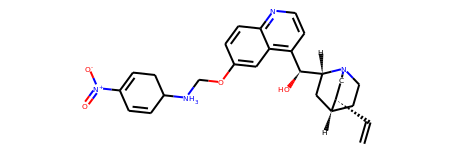

In [17]:
concat_results[0][0]

Boronate: 11715
Amine: 488627
Bromide:
Carboxyl: 713866

In [139]:
with open('amine_prod_temp.sdf','w') as f:
    w = Chem.SDWriter(f)
    for p in prods:
        w.write(p)
    w.close()

In [140]:
with open('amine_prod_temp.smi','w') as f:
    for smi in prodsmi:
        f.write(smi+'\n')

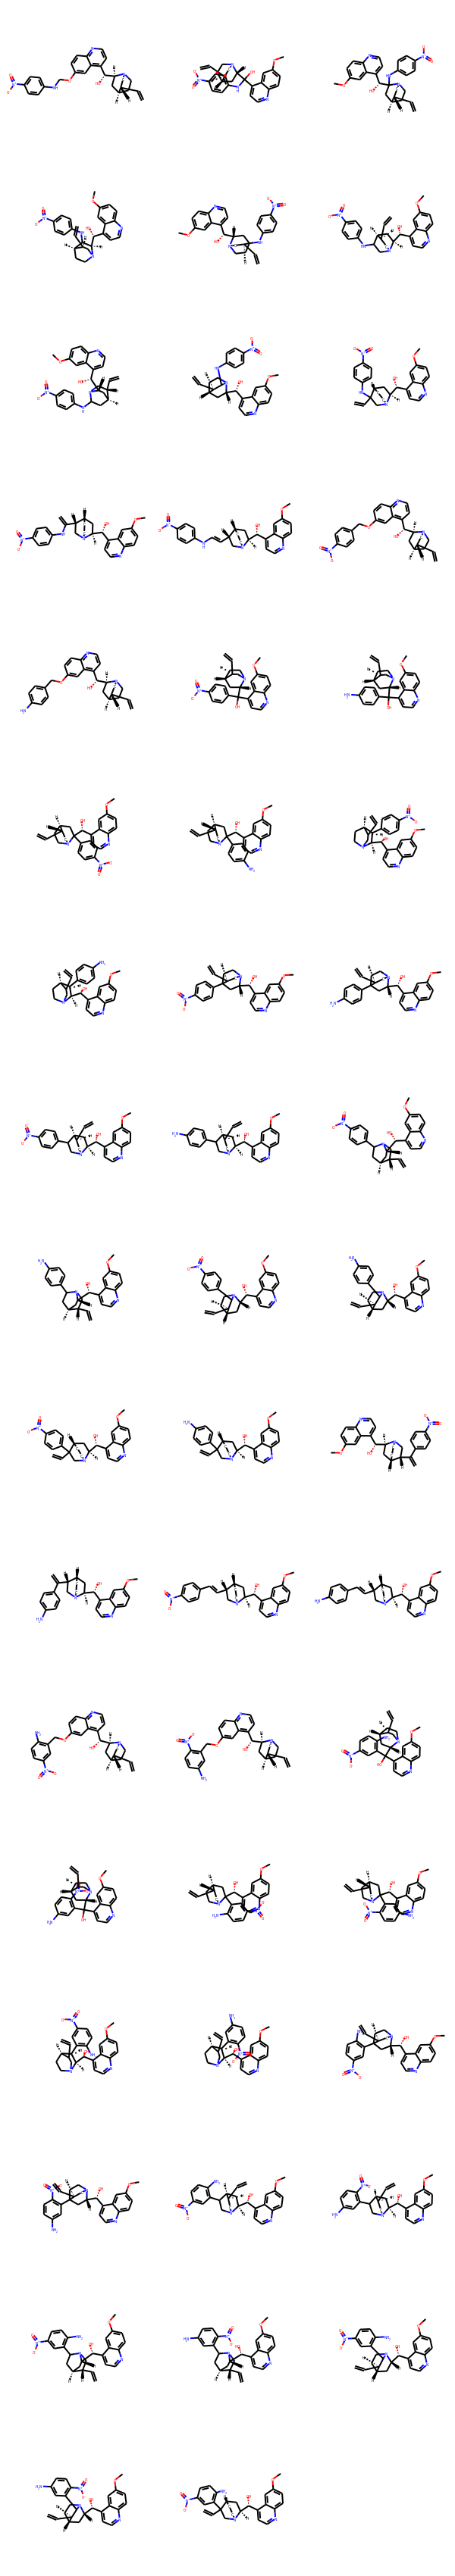

In [142]:
Draw.MolsToGridImage(prods[:50])

In [9]:
df_le10[df_le10['Boron']]

,SMILES,MATERIAL,CAS,PRICE,COPYRIGHT,Mol,Boron,Bromine,Amine,Carboxyl
273,B(O)(O)O,B6768-500G,10043-35-3,55.30,(C) 2020 SIGMA-ALDRICH CO.,<rdkit.Chem.rdchem.Mol object at 0x7f412ad90a30>,True,False,False,True
530,c1cc([o]c1)[B-](F)(F)F.[K+],684961-1G,166328-14-9,80.90,(C) 2020 SIGMA-ALDRICH CO.,<rdkit.Chem.rdchem.Mol object at 0x7f412aeca120>,True,False,False,False
549,B(\C=C\CCC)(O)O,578452-1G,104376-24-1,75.70,(C) 2020 SIGMA-ALDRICH CO.,<rdkit.Chem.rdchem.Mol object at 0x7f412991fb20>,True,False,False,True
605,C1COCC1.B,176192-4X25ML,14044-65-6,91.90,(C) 2020 SIGMA-ALDRICH CO.,<rdkit.Chem.rdchem.Mol object at 0x7f41299235d0>,True,False,False,True
608,FB(F)F.NCC,292249-100G,75-23-0,71.10,(C) 2020 SIGMA-ALDRICH CO.,<rdkit.Chem.rdchem.Mol object at 0x7f41299236c0>,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...
12738,O[B-](c1cccnc1)(O)O.[Na+],BCH00013-1G,NaN,535.00,(C) 2020 SIGMA-ALDRICH CO.,<rdkit.Chem.rdchem.Mol object at 0x7f412ac59a80>,True,False,True,True
12740,O[B-](c1ccc[s]1)(O)O.[Na+],BCH00021-1G,NaN,535.00,(C) 2020 SIGMA-ALDRICH CO.,<rdkit.Chem.rdchem.Mol object at 0x7f412ac59e40>,True,False,True,True
12741,O[B-](c1c[s]cc1)(O)O.[Na+],BCH00022-1G,NaN,535.00,(C) 2020 SIGMA-ALDRICH CO.,<rdkit.Chem.rdchem.Mol object at 0x7f412ac59ad0>,True,False,True,True
12742,Cc1cc(c([s]1)C)B(O)O,BCH00023-1G,162607-23-0,413.00,(C) 2020 SIGMA-ALDRICH CO.,<rdkit.Chem.rdchem.Mol object at 0x7f412ac5b210>,True,False,False,True


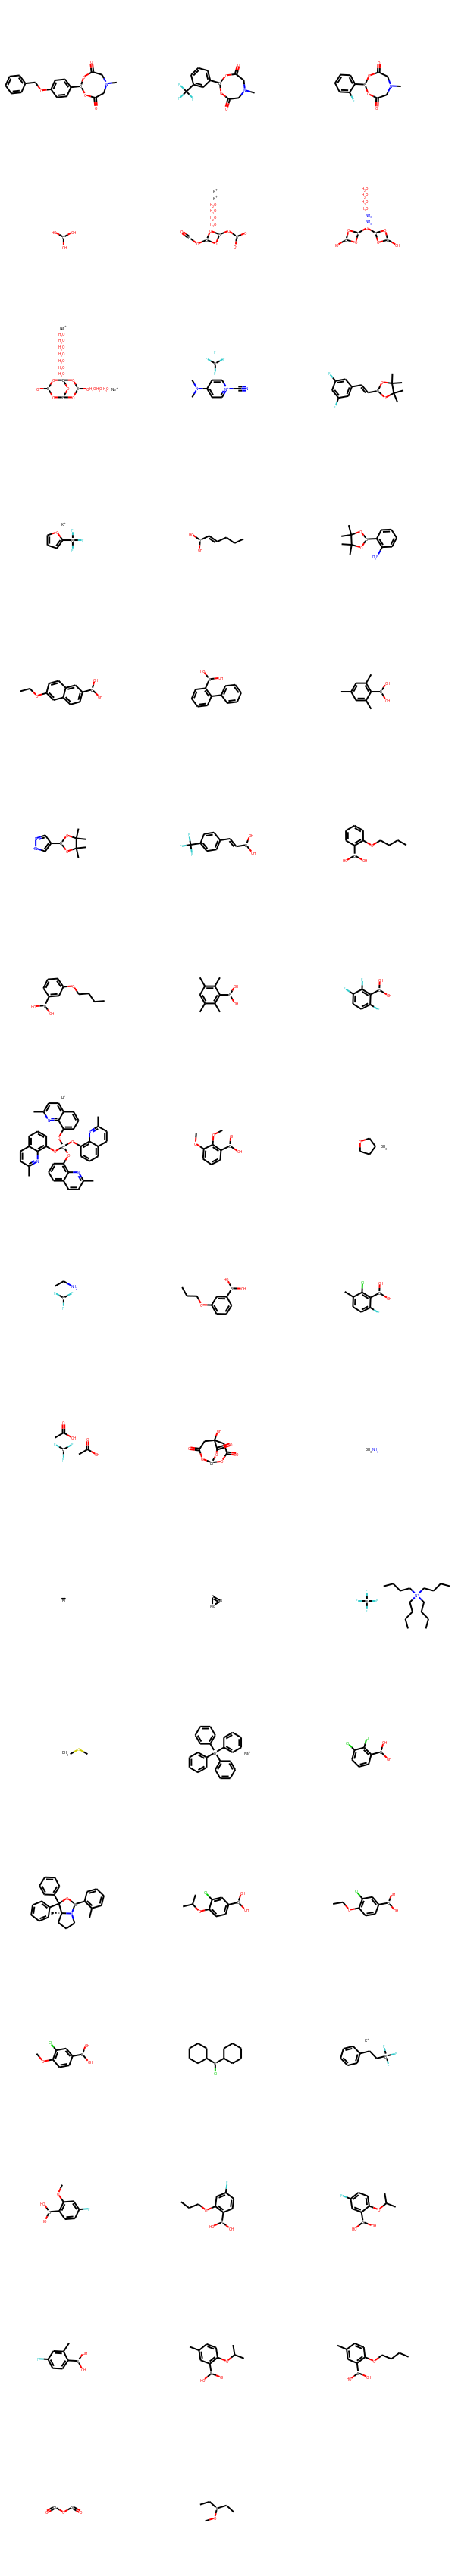

In [37]:
Draw.MolsToGridImage(mols[:50])

In [44]:
m.GetNumHeavyAtoms()

15

In [66]:
mols_le_10 = [m for m in mols if m.GetNumAtoms() <= 10]

In [67]:
len(mols_le_10)

45591

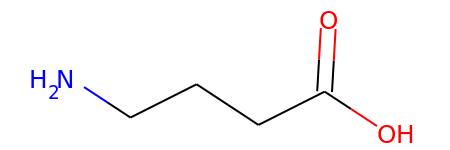

In [74]:
mols_le_10[80]